In [16]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.train import run_model_new
from src.utils_plot import plot_loss_and_all_solution, plot_head_loss
from src.load_save import save_model

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [18]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Wed Feb 28 17:50:42 2024       cuda

+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8              N/A / ERR! |   1108MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

In [20]:
num_heads = 5

alpha_bounds = (10, 25)
def generate_alpha(k, alpha_bounds = alpha_bounds):
  alpha_list = np.zeros(k)
  for i in range(k):
    alpha_list[i] = np.random.uniform(alpha_bounds[0], alpha_bounds[1])
  return alpha_list
alpha_list = generate_alpha(num_heads)


omega_bounds = (0, np.pi)
def generate_omega(k, omega_bounds = omega_bounds):
  omega_list = np.zeros(k)
  for i in range(k):
    omega_list[i] = np.random.uniform(omega_bounds[0], omega_bounds[1])
  return omega_list
#omega_list = generate_omega(num_heads)
omega_list = [1.0 for i in range(num_heads)]


def get_A(alpha):
    return torch.tensor([[2., -1.], [1-alpha, alpha]], device=dev).double() 
A_list = [get_A(i)for i in alpha_list]

def random_IC(x_bound=[0, 2], y_bound=[8, 12]):
    ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
    ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
    return torch.tensor([ICx, ICy], device=dev).double()
#IC_list = [random_IC() for _ in range(num_heads)]
IC_list = [torch.tensor([[2.], [4.]], device=dev).double() for _ in range(num_heads)]

def random_force(force1_bound=[0, 2], force2_bound=[0, 2]):
    force1 = np.random.uniform(force1_bound[0], force1_bound[1], 1)
    force2 = np.random.uniform(force2_bound[0], force2_bound[1], 1)
    return torch.tensor([force1, force2], device=dev).double()
#force_list = [random_force() for i in range(num_heads)]
#force_list =  [lambda t, i=i: [2*torch.sin(t), i*(torch.cos(t)-torch.sin(t))] for i in alpha_list]

force_list = [
    lambda t, alpha=a, omega=w: torch.vstack([2*torch.sin(omega*t), alpha*(torch.cos(omega*t)-torch.sin(omega*t))]).T.double()
    if not isinstance(t, (float, int))
    else np.array([2*np.sin(omega*t), alpha*(np.cos(omega*t)-np.sin(omega*t))]).T
    for a, w in zip(alpha_list, omega_list)
]

equation_name = "linear_exemple1"

In [21]:
x_range = [0, 10]
activation = "silu"
hid_lay = list(np.array([124, 124, 132]))
num_equations = 2
iterations = 10

In [8]:
# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force(t)[..., 0].item()- A[0][1] * y[1] - A[0][0] * y[0],
                     force(t)[..., 1].item() - A[1][0] * y[0] - A[1][1] * y[1]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)

In [9]:
lr = 0.0001
verbose = True
sample_size = 200
decay=True

loss_hist, trained_model, model_time = run_model_new(iterations=iterations, x_range=x_range, lr=lr, A_list=A_list, 
                                                     IC_list=IC_list, force=force_list, hid_lay=hid_lay, activation=activation,
                                                     num_equations=num_equations, num_heads=num_heads, sample_size=sample_size,
                                                     decay=decay, dev=dev, verbose=verbose)

# date tag to save
from datetime import datetime
now = datetime.now()
# Format the date and time as a string in the format 'mmddhhmm'
formatted_datetime = now.strftime('%m%d%H%M')
# Convert the formatted string to an integer
formatted_datetime_int = int(formatted_datetime)

  0%|          | 0/10 [00:00<?, ?it/s]

Iterations 0, L_total = 161.42955321085188, L_ODE = 151.58883117422806, L_IC = 9.840722036623823
Model Training Complete in 3.230 seconds


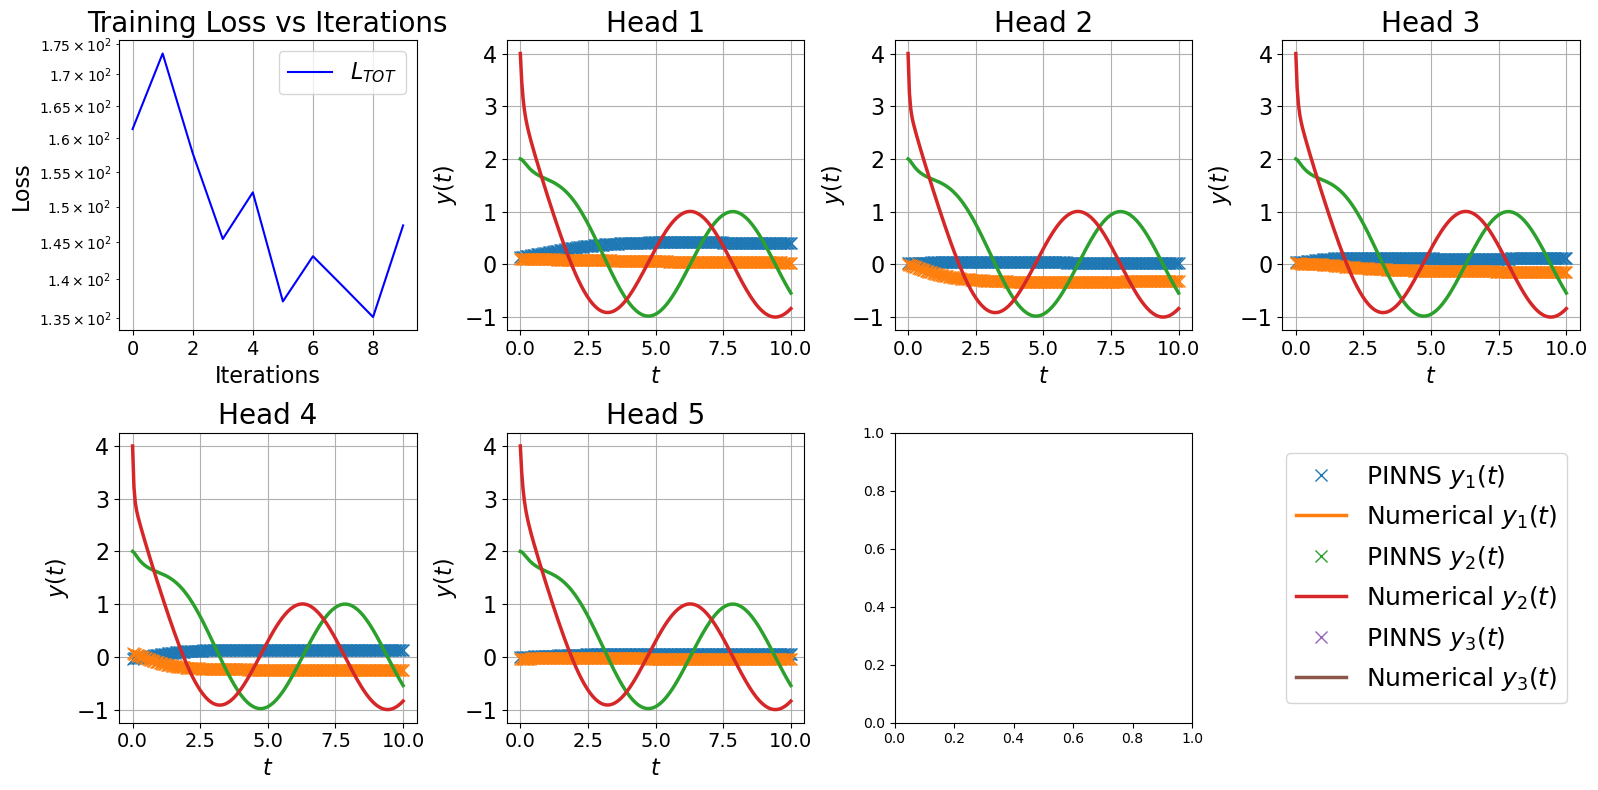

In [10]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct,  
                           trained_model=trained_model, IC_list=IC_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist,  device=dev)

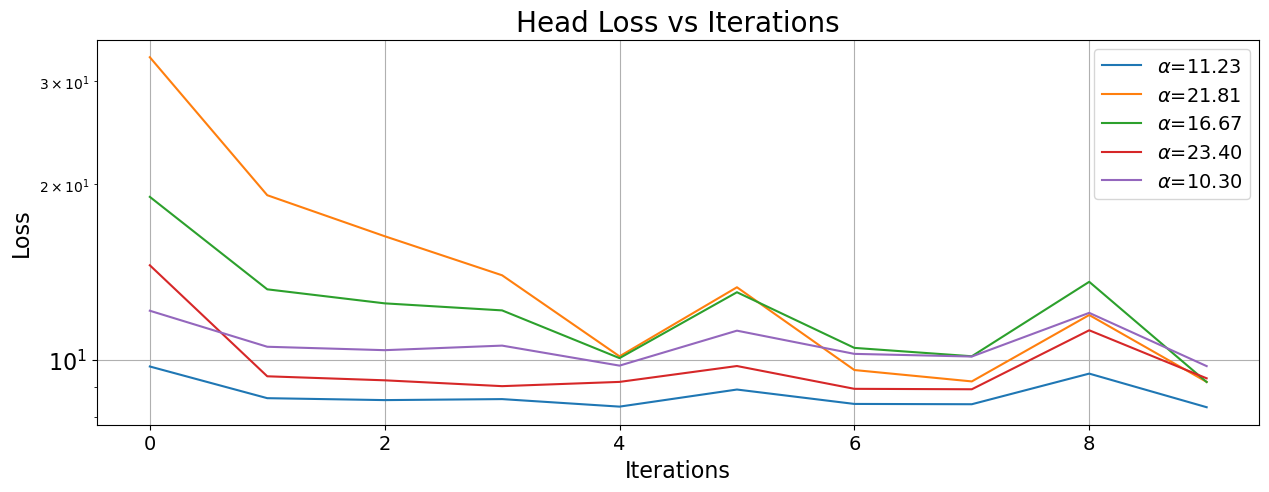

In [11]:
plot_head_loss(loss_hist["head"], alpha_list)

In [12]:
model_name = "big_test"

save_model(trained_model, formatted_datetime_int, equation_name, model_name,
           x_range, iterations, hid_lay, num_equations, num_heads, A_list,
           IC_list, force_list, alpha_list, loss_hist)

D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\model_history/linear_exemple1/history_big_test_2271630.json


# trained multiple stiffness

In [23]:
from tqdm.auto import trange


num_heads = 1
alpha_list = [10, 20, 30, 40]
A_list = [torch.tensor([[2., -1.], [1-i, i]], device=dev).double()  for i in alpha_list]
lr_list = [0.0001, 0.0001, 0.00001, 0.00001]
iterations_list = [20000, 30000, 60000, 80000]
force_list = [
    lambda t, alpha=a, omega=1: torch.vstack([2*torch.sin(omega*t), alpha*(torch.cos(omega*t)-torch.sin(omega*t))]).T.double()
    if not isinstance(t, (float, int))
    else np.array([2*np.sin(omega*t), alpha*(np.cos(omega*t)-np.sin(omega*t))]).T
    for a in alpha_list
]
solution_PINNS = []

rng = np.random.default_rng()
t_eval = torch.arange(x_range[0], x_range[1], 0.001, requires_grad=True, device=dev).double()
t_eval = t_eval[np.concatenate(([0], rng.choice(range(1, len(t_eval)), size=512 - 1, replace=False)))]
t_eval = t_eval.reshape(-1, 1)
t_eval, _ = t_eval.sort(dim=0)

for i in trange(len(alpha_list)):
    _, trained_model, _ = run_model_new(iterations=iterations_list[i], x_range=x_range, lr=lr_list[i], A_list=[A_list[i]], 
                                        IC_list=[IC_list[0]], force=[force_list[i]], hid_lay=hid_lay, activation=activation,
                                        num_equations=num_equations, num_heads=num_heads, sample_size=sample_size,
                                        decay=decay, dev=dev, verbose=verbose)
    solution_PINNS.append(trained_model(t_eval)[0])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

Iterations 0, L_total = 60.019245067753815, L_ODE = 50.39971833075527, L_IC = 9.619526736998544
Iterations 100, L_total = 47.81223465165875, L_ODE = 43.18499942445122, L_IC = 4.6272352272075254
Iterations 200, L_total = 32.56454367133855, L_ODE = 30.991660474343025, L_IC = 1.572883196995524
Iterations 300, L_total = 19.808636339897035, L_ODE = 19.31397141321756, L_IC = 0.49466492667947604
Iterations 400, L_total = 13.143751831500554, L_ODE = 13.005343780484218, L_IC = 0.1384080510163366
Iterations 500, L_total = 11.969667491321722, L_ODE = 11.916310034769293, L_IC = 0.05335745655243011
Iterations 600, L_total = 11.796812257359438, L_ODE = 11.741149311074984, L_IC = 0.055662946284452564
Iterations 700, L_total = 12.211131609707943, L_ODE = 12.132771058526082, L_IC = 0.07836055118186065
Iterations 800, L_total = 11.404745240582486, L_ODE = 11.287443417724527, L_IC = 0.11730182285795815
Iterations 900, L_total = 8.958082664122225, L_ODE = 8.807754281832649, L_IC = 0.15032838228957524
Iter

  0%|          | 0/30000 [00:00<?, ?it/s]

Iterations 0, L_total = 203.66319848513865, L_ODE = 194.01230459392, L_IC = 9.650893891218647
Iterations 100, L_total = 159.90953554093988, L_ODE = 152.54386915428026, L_IC = 7.365666386659618
Iterations 200, L_total = 129.58546705156533, L_ODE = 124.5834351982176, L_IC = 5.002031853347736
Iterations 300, L_total = 74.08681698734954, L_ODE = 70.62245141653325, L_IC = 3.4643655708162773
Iterations 400, L_total = 58.986686338003395, L_ODE = 56.56292507040322, L_IC = 2.4237612676001774
Iterations 500, L_total = 50.02187686713284, L_ODE = 48.3198992860065, L_IC = 1.7019775811263345
Iterations 600, L_total = 44.54268292981974, L_ODE = 43.31786287007282, L_IC = 1.2248200597469148
Iterations 700, L_total = 37.088639494716666, L_ODE = 36.1886050899635, L_IC = 0.9000344047531625
Iterations 800, L_total = 33.27905485206824, L_ODE = 32.58662877172036, L_IC = 0.6924260803478798
Iterations 900, L_total = 34.11006165630329, L_ODE = 33.518991789525856, L_IC = 0.5910698667774329
Iterations 1000, L_tot

  0%|          | 0/60000 [00:00<?, ?it/s]

Iterations 0, L_total = 430.6873558749999, L_ODE = 420.26782228521336, L_IC = 10.419533589786557
Iterations 100, L_total = 429.4662747405635, L_ODE = 419.2463534341968, L_IC = 10.219921306366718
Iterations 200, L_total = 419.84800223766115, L_ODE = 409.8853385097196, L_IC = 9.962663727941585
Iterations 300, L_total = 373.3494305521455, L_ODE = 363.6157612889969, L_IC = 9.733669263148611
Iterations 400, L_total = 348.38468373658, L_ODE = 338.8924760496279, L_IC = 9.492207686952076
Iterations 500, L_total = 394.4686064128786, L_ODE = 385.2145623864014, L_IC = 9.25404402647725
Iterations 600, L_total = 426.09646029471685, L_ODE = 417.0746888964289, L_IC = 9.021771398287942
Iterations 700, L_total = 377.19148837523045, L_ODE = 368.3993055522133, L_IC = 8.792182823017116
Iterations 800, L_total = 356.70403129713435, L_ODE = 348.1235620907761, L_IC = 8.580469206358252
Iterations 900, L_total = 340.77140490140346, L_ODE = 332.3848669795817, L_IC = 8.386537921821743
Iterations 1000, L_total = 

  0%|          | 0/80000 [00:00<?, ?it/s]

Iterations 0, L_total = 772.6945497271182, L_ODE = 762.1017849634417, L_IC = 10.592764763676515
Iterations 100, L_total = 667.6710683174529, L_ODE = 657.2033894090399, L_IC = 10.467678908412937
Iterations 200, L_total = 675.4748614411136, L_ODE = 665.1753585970924, L_IC = 10.299502844021145
Iterations 300, L_total = 683.195368691654, L_ODE = 673.0473311263912, L_IC = 10.148037565262843
Iterations 400, L_total = 701.9315936571484, L_ODE = 691.9401977924616, L_IC = 9.991395864686782
Iterations 500, L_total = 701.2417889778211, L_ODE = 691.4091627028499, L_IC = 9.832626274971176
Iterations 600, L_total = 696.5213029316938, L_ODE = 686.8381396567395, L_IC = 9.683163274954225
Iterations 700, L_total = 594.1705553879336, L_ODE = 584.6528781259889, L_IC = 9.517677261944744
Iterations 800, L_total = 642.5678604304154, L_ODE = 633.2033784118082, L_IC = 9.364482018607202
Iterations 900, L_total = 672.8365534233968, L_ODE = 663.6301488439567, L_IC = 9.20640457944015
Iterations 1000, L_total = 604

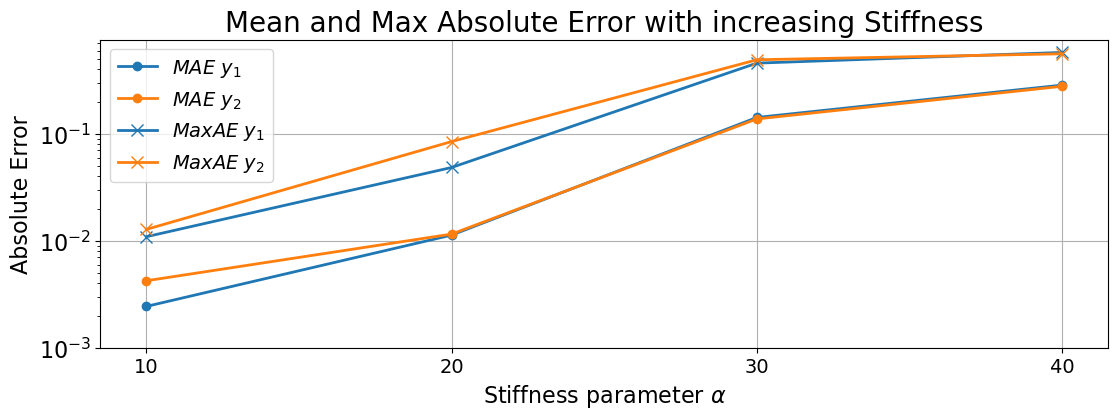

In [31]:
mae_y1 = []
mae_y2 = []
maxae_y1 = []
maxae_y2 = []

for i in range(len(alpha_list)):
    pinns = solution_PINNS[i].detach().cpu().numpy()
    numerical = numerical_sol_fct(t_eval.detach().cpu().numpy(),
                                  IC_list[0].detach().cpu().numpy(),
                                  A_list[i].detach().cpu().numpy(),
                                  force_list[i]).T
    absolute_error = np.abs(pinns[:, 0, :] - numerical)
    mae_y1.append(absolute_error.mean(0)[0])
    mae_y2.append(absolute_error.mean(0)[1])
    maxae_y1.append(absolute_error.max(0)[0])
    maxae_y2.append(absolute_error.max(0)[1])

fig, ax = plt.subplots(1, figsize=(13, 4))

ax.plot(alpha_list, mae_y1, "-o", label="$MAE$ ${y_1}$", linewidth=2, markersize=6)
ax.plot(alpha_list, mae_y2,"-o", label="$MAE$ ${y_2}$", linewidth=2, markersize=6)
ax.plot(alpha_list, maxae_y1, "-x", color="#1f77b4", label="$MaxAE$ ${y_1}$", linewidth=2, markersize=8)
ax.plot(alpha_list, maxae_y2, "-x", color="#ff7f0e", label="$MaxAE$ ${y_2}$", linewidth=2, markersize=8)

ax.set_yscale("log")
ax.set_title(r"Mean and Max Absolute Error with increasing Stiffness", fontsize=20)
ax.set_xlabel(r'Stiffness parameter $\alpha$', fontsize=16)
ax.set_ylabel('Absolute Error', fontsize=16)
ax.set_xticks(alpha_list, alpha_list)
ax.set_yticks([0.1, 0.01, 0.001],
              [r"$10^{-1}$", r"$10^{-2}$", r"$10^{-3}$"])
ax.grid()
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=16)
ax.legend(loc='best', fontsize=14)

In [35]:
# import json

# history = {}
# history["alpha_list"] = alpha_list
# history["mae_y1"] = mae_y1
# history["mae_y2"] = mae_y2
# history["maxae_y1"] = maxae_y1
# history["maxae_y2"] = maxae_y2

# with open(r"D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\result_history\Example1_Error_Trained.json",  "w") as fp:
#     json.dump(history, fp)